In [40]:
# Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
import os
from PIL import Image
import math

print("All libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
OpenCV version: 4.11.0
NumPy version: 1.26.4


In [41]:
from skimage.morphology import skeletonize

In [42]:
img = cv2.imread('/Users/mac/Downloads/LineDetection/Imgtotest.jpg', 0)

In [43]:
ret_otsu, thresh_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

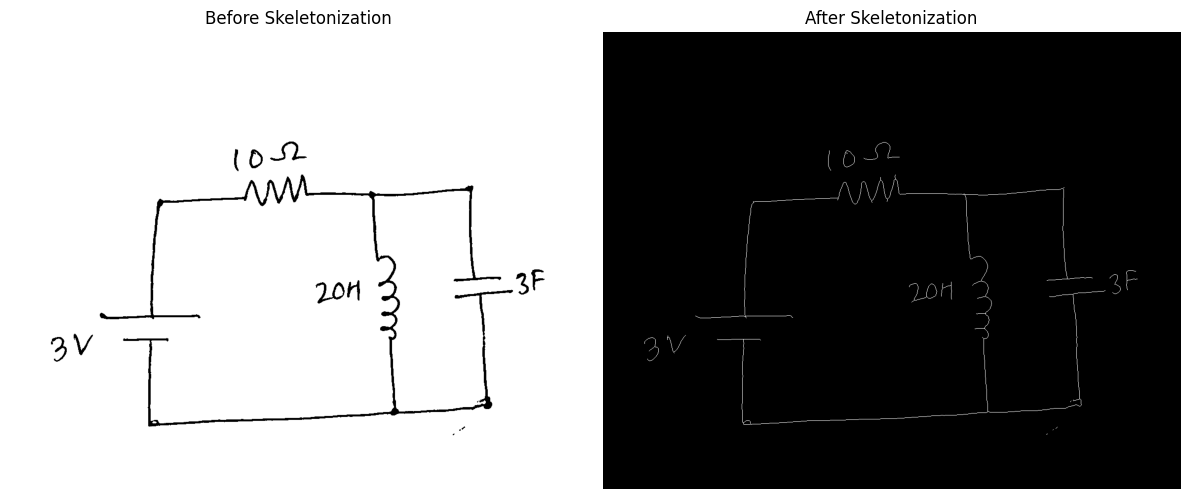

Skeletonization complete. The skeleton represents the centerline of the strokes.


True

In [47]:
invertedopened = cv2.bitwise_not(thresh_otsu)


skeleton = skeletonize(invertedopened / 255)

skeleton_img = (skeleton * 255).astype(np.uint8)

# --- Display Skeletonization Result ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(thresh_otsu, cmap='gray')
plt.title('Before Skeletonization')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(skeleton_img, cmap='gray')
plt.title('After Skeletonization')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Skeletonization complete. The skeleton represents the centerline of the strokes.")

cv2.imwrite("/Users/mac/Downloads/LineDetection/HorandVertNewMethod/skeleton_img.png", skeleton_img)

Processing 14 lines from file...
Successfully removed 8 components. Kept Junctions.


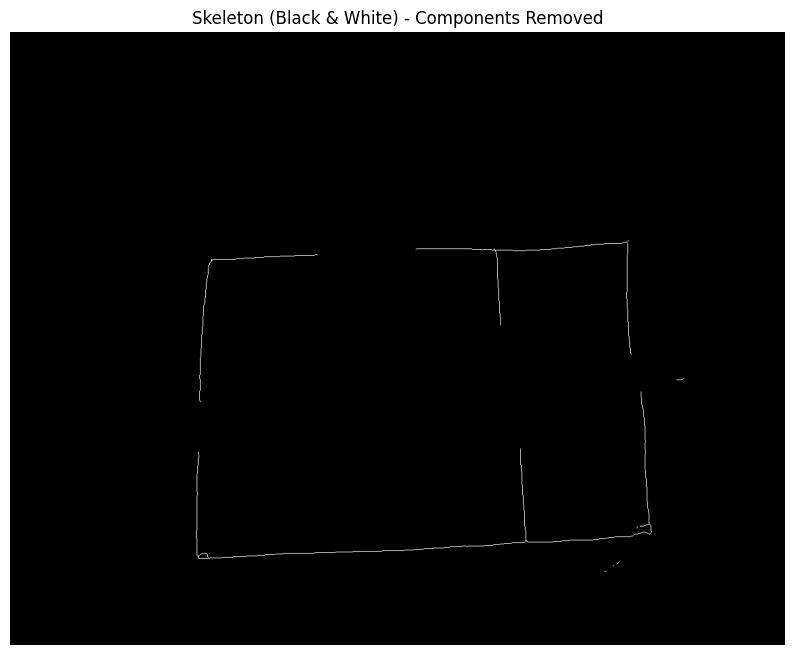

In [49]:
import cv2
import matplotlib.pyplot as plt

def remove_components(image, label_path):
    # 1. FORCE GRAYSCALE (Black and White)
    # If the image has 3 channels (BGR/RGB), convert to 1 channel (Grayscale)
    if len(image.shape) == 3:
        cleaned_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        cleaned_img = image.copy()
    
    # Get image dimensions
    img_h, img_w = cleaned_img.shape[:2]
    
    # 2. DEFINE ERASER FOR GRAYSCALE
    # For single channel images, Black is just 0 (scalar), not a tuple (0,0,0)
    ERASER_COLOR = 0 
    
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        print(f"Processing {len(lines)} lines from file...")
        
        removed_count = 0
        
        for line in lines:
            parts = line.strip().split()
            if not parts: continue
            
            class_id = int(parts[0])
            
            # LOGIC: If it is NOT a junction (1), remove it
            if class_id != 1:
                # Parse normalized coordinates (0 to 1)
                x_center, y_center = float(parts[1]), float(parts[2])
                box_w, box_h = float(parts[3]), float(parts[4])
                
                # Convert to pixel coordinates
                x1 = int((x_center - box_w / 2) * img_w)
                y1 = int((y_center - box_h / 2) * img_h)
                x2 = int((x_center + box_w / 2) * img_w)
                y2 = int((y_center + box_h / 2) * img_h)
                
                # Clip coordinates
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(img_w, x2), min(img_h, y2)
                
                # Draw filled black rectangle
                cv2.rectangle(cleaned_img, (x1, y1), (x2, y2), ERASER_COLOR, thickness=-1)
                
                removed_count += 1
                
        print(f"Successfully removed {removed_count} components. Kept Junctions.")
        return cleaned_img

    except FileNotFoundError:
        print(f"Error: The file {label_path} was not found.")
        return image

# --- EXECUTION ---

txt_path = '/Users/mac/Downloads/LineDetection/Imgtotest.txt'

# Assumes 'skeleton_img' is already loaded
if 'skeleton_img' in locals():
    # Run the removal (Returns a Grayscale image)
    final_skeleton = remove_components(skeleton_img, txt_path)

    # 3. Show Result in Black and White
    plt.figure(figsize=(10, 10))
    
    # 'cmap="gray"' ensures it interprets the values as Black/White
    # 'vmin=0, vmax=255' ensures strictly black (0) to white (255) contrast
    plt.imshow(final_skeleton, cmap='gray', vmin=0, vmax=255)
    
    plt.title("Skeleton (Black & White) - Components Removed")
    plt.axis('off')
    plt.show()
    
    # Save the result as a proper grayscale PNG
    # cv2.imwrite("clean_skeleton_bw.png", final_skeleton)

else:
    print("Please load 'skeleton_img' first.")

In [54]:

def process_circuit_wires(skeleton_img_data, label_file_path):
    # 1. Get Dimensions based on the image itself
    img_h, img_w = skeleton_img_data.shape[:2]
    print(f"Processing Image: {img_w}x{img_h}")

    if not os.path.exists(label_file_path):
        print(f"Error: File not found at {label_file_path}")
        return []

    # 2. Read Junctions (Class 1 only)
    junctions = []
    with open(label_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts or int(parts[0]) != 1: continue
            # De-normalize coordinates
            norm_x, norm_y = float(parts[1]), float(parts[2])
            junctions.append((norm_x * img_w, norm_y * img_h))

    print(f"Found {len(junctions)} junctions to analyze.")

    # 3. Geometric Helper Functions
    def get_orientation(p1, p2):
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        if dx == 0: return "VERTICAL"
        angle = math.degrees(math.atan2(dy, dx)) % 360
        # 10% tolerance zones (~18 degrees)
        if (0 <= angle <= 18) or (342 <= angle <= 360) or (162 <= angle <= 198): return "HORIZONTAL"
        if (72 <= angle <= 108) or (252 <= angle <= 288): return "VERTICAL"
        return None

    def snap(val): return round(val / 16) * 16

    # 4. Pairwise Analysis, Alignment, and Snapping
    valid_wires = []
    for i, p1 in enumerate(junctions):
        for p2 in junctions[i+1:]:
            ort = get_orientation(p1, p2)
            if ort:
                if ort == "HORIZONTAL":
                    avg_y = (p1[1] + p2[1]) / 2
                    s, e = (p1[0], avg_y), (p2[0], avg_y)
                else: # VERTICAL
                    avg_x = (p1[0] + p2[0]) / 2
                    s, e = (avg_x, p1[1]), (avg_x, p2[1])
                
                # Snap and ensure integers for drawing later
                final_s = (int(snap(s[0])), int(snap(s[1])))
                final_e = (int(snap(e[0])), int(snap(e[1])))

                if final_s != final_e:
                    valid_wires.append({'start': final_s, 'end': final_e, 'type': ort})
    return valid_wires



def draw_results(original_img_data, wires_list):
    h, w = original_img_data.shape[:2]

    # A. Create Blank Sheet (Black background)
    blank_sheet = np.zeros((h, w, 3), dtype=np.uint8)

    # B. Create Overlay (Copy original so we don't edit it directly)
    overlay_img = original_img_data.copy()

    # Define Colors (BGR format for OpenCV)
    HORIZ_COLOR = (0, 255, 0)   # Green
    VERT_COLOR = (0, 0, 255)    # Red
    THICKNESS = 1

    print(f"Drawing {len(wires_list)} detected wires...")

    for wire in wires_list:
        pt1 = wire['start']
        pt2 = wire['end']
        color = HORIZ_COLOR if wire['type'] == "HORIZONTAL" else VERT_COLOR

        # 1. Draw on blank sheet
        cv2.line(blank_sheet, pt1, pt2, color, THICKNESS)

        # 2. Draw on top of the skeleton image overlay
        cv2.line(overlay_img, pt1, pt2, color, THICKNESS)
        # Optional: Draw circles at the snapped start/end points
        cv2.circle(overlay_img, pt1, 4, color, -1)
        cv2.circle(overlay_img, pt2, 4, color, -1)

    # Save results
    cv2.imwrite("/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet.png", blank_sheet)
    cv2.imwrite("/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_overlay.png", overlay_img)
    print("Successfully saved 'output_blank_sheet.png' and 'output_overlay.png'")


if __name__ == "__main__":

    txt_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"


    # 1. Process
    detected_wires = process_circuit_wires(final_skeleton, txt_path)

    # 2. Visualize
    draw_results(display_img, detected_wires)

Processing Image: 1171x926
Found 6 junctions to analyze.
Drawing 9 detected wires...
Successfully saved 'output_blank_sheet.png' and 'output_overlay.png'


In [ ]:
import math
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


def process_circuit_wires(skeleton_img_data, label_file_path):
    # Get Dimensions based on the image itself
    img_h, img_w = skeleton_img_data.shape[:2]
    print(f"Processing Image: {img_w}x{img_h}")

    if not os.path.exists(label_file_path):
        print(f"Error: File not found at {label_file_path}")
        return []

    # Read Junctions (Class 1 only)
    junctions = []
    with open(label_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts or int(parts[0]) != 1: continue
            # De-normalize coordinates
            norm_x, norm_y = float(parts[1]), float(parts[2])
            junctions.append((norm_x * img_w, norm_y * img_h))

    print(f"Found {len(junctions)} junctions to analyze.")

    # Geometric Helper Functions
    def get_orientation(p1, p2):
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        if dx == 0: return "VERTICAL"
        angle = math.degrees(math.atan2(dy, dx)) % 360
        # 10% tolerance zones (~18 degrees)
        if (0 <= angle <= 18) or (342 <= angle <= 360) or (162 <= angle <= 198): return "HORIZONTAL"
        if (72 <= angle <= 108) or (252 <= angle <= 288): return "VERTICAL"
        return None

    def snap(val): return round(val / 16) * 16

    # Pairwise Analysis, Alignment, and Snapping
    valid_wires = []
    for i, p1 in enumerate(junctions):
        for p2 in junctions[i+1:]:
            ort = get_orientation(p1, p2)
            if ort:
                if ort == "HORIZONTAL":
                    avg_y = (p1[1] + p2[1]) / 2
                    s, e = (p1[0], avg_y), (p2[0], avg_y)
                else: # VERTICAL
                    avg_x = (p1[0] + p2[0]) / 2
                    s, e = (avg_x, p1[1]), (avg_x, p2[1])
                
                # Snap and ensure integers for drawing later
                final_s = (int(snap(s[0])), int(snap(s[1])))
                final_e = (int(snap(e[0])), int(snap(e[1])))

                if final_s != final_e:
                    valid_wires.append({'start': final_s, 'end': final_e, 'type': ort})
    return valid_wires

def draw_results(original_img_data, wires_list):
    h, w = original_img_data.shape[:2]

    # Create Blank Sheet (Black background)
    blank_sheet = np.zeros((h, w, 3), dtype=np.uint8)

    # Create Overlay (Handle Grayscale or Color input)
    if len(original_img_data.shape) == 2:
        overlay_img = cv2.cvtColor(original_img_data, cv2.COLOR_GRAY2BGR)
    else:
        overlay_img = original_img_data.copy()

    # Define Colors (BGR format)
    HORIZ_COLOR = (0, 255, 0)   # Green
    VERT_COLOR = (0, 0, 255)    # Red
    TEXT_COLOR = (255, 255, 255)
    THICKNESS = 1

    for wire in wires_list:
        pt1 = wire['start']
        pt2 = wire['end']
        color = HORIZ_COLOR if wire['type'] == "HORIZONTAL" else VERT_COLOR

        # Draw lines
        cv2.line(blank_sheet, pt1, pt2, color, THICKNESS)
        cv2.line(overlay_img, pt1, pt2, color, THICKNESS)
        
        # Draw circles
        cv2.circle(overlay_img, pt1, 3, color, -1)
        cv2.circle(overlay_img, pt2, 3, color, -1)
        cv2.circle(blank_sheet, pt1, 3, color, -1)
        cv2.circle(blank_sheet, pt2, 3, color, -1)

        # Draw Text Coordinates
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        text_pt1 = f"{pt1}"
        text_pt2 = f"{pt2}"
        
        cv2.putText(blank_sheet, text_pt1, (pt1[0]+5, pt1[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(blank_sheet, text_pt2, (pt2[0]+5, pt2[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(overlay_img, text_pt1, (pt1[0]+5, pt1[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(overlay_img, text_pt2, (pt2[0]+5, pt2[1]-5), font, font_scale, TEXT_COLOR, 1)

    # Save results
    output_dir = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(output_dir + "output_blank_sheet.png", blank_sheet)
    cv2.imwrite(output_dir + "output_overlay.png", overlay_img)
    print("Successfully saved images to:", output_dir)



if __name__ == "__main__":
    txt_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"

    # NOTE: 'final_skeleton' must be loaded in your environment from the previous step.
    # If starting fresh, uncomment the line below:
    # final_skeleton = cv2.imread("/path/to/your/cleaned_skeleton.png", cv2.IMREAD_GRAYSCALE)

    if 'final_skeleton' in locals():
        
        # 1. Process
        detected_wires = process_circuit_wires(final_skeleton, txt_path)

        # 2. PRINT COORDINATES TO TERMINAL
        print("\n" + "="*40)
        print("       DETECTED WIRE COORDINATES")
        print("="*40)
        
        for i, wire in enumerate(detected_wires):
            w_type = wire['type']
            start = wire['start']
            end = wire['end']
            print(f"Wire {i+1} [{w_type}]: {start} --> {end}")
            
        print("="*40 + "\n")

        # 3. Visualize (Draw and Save)
        draw_results(final_skeleton, detected_wires)
        
    else:
        print("Error: 'final_skeleton' image variable is not defined.")

Processing Image: 1171x926
Found 6 junctions to analyze.

       DETECTED WIRE COORDINATES
Wire 1 [VERTICAL]: (752, 768) --> (752, 336)
Wire 2 [HORIZONTAL]: (784, 784) --> (288, 784)
Wire 3 [HORIZONTAL]: (784, 752) --> (976, 752)
Wire 4 [HORIZONTAL]: (928, 320) --> (736, 320)
Wire 5 [HORIZONTAL]: (928, 336) --> (304, 336)
Wire 6 [VERTICAL]: (944, 320) --> (944, 752)
Wire 7 [HORIZONTAL]: (736, 336) --> (304, 336)
Wire 8 [VERTICAL]: (288, 800) --> (288, 352)
Wire 9 [HORIZONTAL]: (288, 768) --> (976, 768)

Successfully saved images to: /Users/mac/Downloads/LineDetection/HorandVertNewMethod/


In [ ]:
import math
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def process_circuit_wires(skeleton_img_data, label_file_path):
    img_h, img_w = skeleton_img_data.shape[:2]
    print(f"Processing Image: {img_w}x{img_h}")

    if not os.path.exists(label_file_path):
        print(f"Error: File not found at {label_file_path}")
        return []

    # Read Junctions (Class 1 only)
    junctions = []
    with open(label_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts or int(parts[0]) != 1: continue
            norm_x, norm_y = float(parts[1]), float(parts[2])
            junctions.append((norm_x * img_w, norm_y * img_h))

    print(f"Found {len(junctions)} junctions to analyze.")

    def get_orientation(p1, p2):
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        if dx == 0: return "VERTICAL"
        angle = math.degrees(math.atan2(dy, dx)) % 360
        # 10% tolerance zones
        if (0 <= angle <= 18) or (342 <= angle <= 360) or (162 <= angle <= 198): return "HORIZONTAL"
        if (72 <= angle <= 108) or (252 <= angle <= 288): return "VERTICAL"
        return None

    def snap(val): return round(val / 16) * 16

    raw_wires = []
    for i, p1 in enumerate(junctions):
        for p2 in junctions[i+1:]:
            ort = get_orientation(p1, p2)
            if ort:
                if ort == "HORIZONTAL":
                    avg_y = (p1[1] + p2[1]) / 2
                    s, e = (p1[0], avg_y), (p2[0], avg_y)
                else: 
                    avg_x = (p1[0] + p2[0]) / 2
                    s, e = (avg_x, p1[1]), (avg_x, p2[1])
                
                final_s = (int(snap(s[0])), int(snap(s[1])))
                final_e = (int(snap(e[0])), int(snap(e[1])))

                if final_s != final_e:
                    raw_wires.append({'start': final_s, 'end': final_e, 'type': ort})
    return raw_wires


# ==========================================
# 2. CONSOLIDATION LOGIC (Merge to Bigger Line)
# ==========================================
def consolidate_wires(wires_list, grid_tolerance=16):
    if not wires_list: return []

    # Separate by orientation
    horizontals = []
    verticals = []

    for w in wires_list:
        p1, p2 = w['start'], w['end']
        
        if w['type'] == 'HORIZONTAL':
            if p1[0] > p2[0]: p1, p2 = p2, p1
            horizontals.append({'axis': p1[1], 'min': p1[0], 'max': p2[0], 'type': 'HORIZONTAL'})
            
        elif w['type'] == 'VERTICAL':
            if p1[1] > p2[1]: p1, p2 = p2, p1
            verticals.append({'axis': p1[0], 'min': p1[1], 'max': p2[1], 'type': 'VERTICAL'})

    def merge_segments(items):
        if not items: return []
        
        # Sort by Axis, then by Start point
        items.sort(key=lambda x: (x['axis'], x['min']))
        
        merged = []
        current = items[0]
        
        for next_item in items[1:]:
            # 1. Check Proximity
            axis_diff = abs(current['axis'] - next_item['axis'])
            overlap = next_item['min'] <= (current['max'] + grid_tolerance)
            
            if axis_diff <= grid_tolerance and overlap:
                # --- MERGE LOGIC MODIFIED HERE ---
                
                # Calculate Lengths
                len_curr = current['max'] - current['min']
                len_next = next_item['max'] - next_item['min']
                
                # Determine which axis to keep (The Bigger Line wins)
                if len_next > len_curr:
                    current['axis'] = next_item['axis']
                # Else: keep current['axis'] because it is bigger (or equal)

                # Extend the bounds
                current['max'] = max(current['max'], next_item['max'])
                current['min'] = min(current['min'], next_item['min'])
                
            else:
                merged.append(current)
                current = next_item
        
        merged.append(current)
        return merged

    final_horz = merge_segments(horizontals)
    final_vert = merge_segments(verticals)
    
    # Reconstruct
    consolidated_list = []
    for h in final_horz:
        consolidated_list.append({
            'start': (h['min'], h['axis']),
            'end':   (h['max'], h['axis']),
            'type': 'HORIZONTAL'
        }) 
    for v in final_vert:
        consolidated_list.append({
            'start': (v['axis'], v['min']),
            'end':   (v['axis'], v['max']),
            'type': 'VERTICAL'
        })
        
    return consolidated_list



def draw_results(original_img_data, wires_list):
    h, w = original_img_data.shape[:2]

    blank_sheet = np.zeros((h, w, 3), dtype=np.uint8)

    if len(original_img_data.shape) == 2:
        overlay_img = cv2.cvtColor(original_img_data, cv2.COLOR_GRAY2BGR)
    else:
        overlay_img = original_img_data.copy()

    HORIZ_COLOR = (0, 255, 0)
    VERT_COLOR = (0, 0, 255)
    TEXT_COLOR = (255, 255, 255)
    THICKNESS = 1

    print(f"Drawing {len(wires_list)} consolidated wires...")

    for wire in wires_list:
        pt1 = wire['start']
        pt2 = wire['end']
        color = HORIZ_COLOR if wire['type'] == "HORIZONTAL" else VERT_COLOR

        cv2.line(blank_sheet, pt1, pt2, color, THICKNESS)
        cv2.line(overlay_img, pt1, pt2, color, THICKNESS)
        
        cv2.circle(overlay_img, pt1, 3, color, -1)
        cv2.circle(overlay_img, pt2, 3, color, -1)
        cv2.circle(blank_sheet, pt1, 3, color, -1)
        cv2.circle(blank_sheet, pt2, 3, color, -1)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        
        cv2.putText(blank_sheet, f"{pt1}", (pt1[0]+5, pt1[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(blank_sheet, f"{pt2}", (pt2[0]+5, pt2[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(overlay_img, f"{pt1}", (pt1[0]+5, pt1[1]-5), font, font_scale, TEXT_COLOR, 1)
        cv2.putText(overlay_img, f"{pt2}", (pt2[0]+5, pt2[1]-5), font, font_scale, TEXT_COLOR, 1)

    output_dir = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cv2.imwrite(output_dir + "output_blank_sheet.png", blank_sheet)
    cv2.imwrite(output_dir + "output_overlay.png", overlay_img)
    print("Successfully saved images to:", output_dir)

if __name__ == "__main__":
    txt_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"

    # Ensure 'final_skeleton' is loaded.
    if 'final_skeleton' in locals():
        
        # A. Detect Raw Pairs
        raw_wires = process_circuit_wires(final_skeleton, txt_path)
        print(f"Raw detected pairs: {len(raw_wires)}")

        # B. Consolidate (Merge to Bigger Line)
        final_wires = consolidate_wires(raw_wires, grid_tolerance=16)
        print(f"Final merged wires: {len(final_wires)}")

        # C. Print Coordinates
        print("\n" + "="*40)
        print("       FINAL MERGED COORDINATES")
        print("="*40)
        
        for i, wire in enumerate(final_wires):
            print(f"Wire {i+1} [{wire['type']}]: {wire['start']} --> {wire['end']}")
            
        print("="*40 + "\n")

        # D. Visualize
        draw_results(final_skeleton, final_wires)
        
    else:
        print("Error: 'final_skeleton' image variable is not defined.")

Processing Image: 1171x926
Found 6 junctions to analyze.
Raw detected pairs: 9
Final merged wires: 5

       FINAL MERGED COORDINATES
Wire 1 [HORIZONTAL]: (304, 336) --> (928, 336)
Wire 2 [HORIZONTAL]: (288, 768) --> (976, 768)
Wire 3 [VERTICAL]: (288, 352) --> (288, 800)
Wire 4 [VERTICAL]: (752, 336) --> (752, 768)
Wire 5 [VERTICAL]: (944, 320) --> (944, 752)

Drawing 5 consolidated wires...
Successfully saved images to: /Users/mac/Downloads/LineDetection/HorandVertNewMethod/


In [108]:
import cv2
import os

def draw_bounding_boxes_on_image(image_path, label_path, output_path):
    """
    Overlays bounding boxes from a text file onto an image, EXCLUDING Class 0.
    """
    # 1. Load the base image
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return
    image = cv2.imread(image_path)
    img_h, img_w = image.shape[:2]

    # 2. Load bounding box data
    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return

    with open(label_path, 'r') as f:
        lines = f.readlines()

    print(f"Processing boxes on {os.path.basename(image_path)}...")

    # Define colors (BGR)
    BOX_COLOR = (0, 255, 255)  # Yellow
    TEXT_COLOR = (0, 255, 255) # Yellow

    drawn_count = 0

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue

        class_id = int(parts[0])

        # --- FILTER: DO NOT DRAW CLASS 0 ---
        if class_id == 0 or class_id == 1:
            continue

        try:
            norm_x, norm_y = float(parts[1]), float(parts[2])
            norm_w, norm_h = float(parts[3]), float(parts[4])
        except ValueError:
            continue

        # Convert YOLO format to pixel coordinates
        x1 = int((norm_x - norm_w / 2) * img_w)
        y1 = int((norm_y - norm_h / 2) * img_h)
        x2 = int((norm_x + norm_w / 2) * img_w)
        y2 = int((norm_y + norm_h / 2) * img_h)

        # 3. Draw rectangle and label
        cv2.rectangle(image, (x1, y1), (x2, y2), BOX_COLOR, 2)
        
        # Place text above the box
        text_y = y1 - 5 if y1 > 15 else y1 + 15
        cv2.putText(image, f"ID: {class_id}", (x1, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, 1)
        
        drawn_count += 1

    # 4. Save result
    cv2.imwrite(output_path, image)
    print(f"Successfully saved to {output_path}")
    print(f"Total boxes drawn: {drawn_count} (Class 0 excluded)")


# --- Execution ---
if __name__ == "__main__":
    base_image_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet.png"
    label_file_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"
    final_output_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet_with_boxes.png"

    draw_bounding_boxes_on_image(base_image_path, label_file_path, final_output_path)

Processing boxes on output_blank_sheet.png...
Successfully saved to /Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet_with_boxes.png
Total boxes drawn: 4 (Class 0 excluded)


In [ ]:
import cv2
import numpy as np
import os
import math


def get_component_boxes(label_path, img_w, img_h):
    """Extracts bounding boxes for components (Excluding 0 and 1)."""
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue
        
        class_id = int(parts[0])
        # Exclude Text(0) and Junctions(1)
        if class_id == 0 or class_id == 1:
            continue

        norm_x, norm_y = float(parts[1]), float(parts[2])
        norm_w, norm_h = float(parts[3]), float(parts[4])

        # Convert to pixel coordinates (x1, y1, x2, y2)
        x1 = int((norm_x - norm_w / 2) * img_w)
        y1 = int((norm_y - norm_h / 2) * img_h)
        x2 = int((norm_x + norm_w / 2) * img_w)
        y2 = int((norm_y + norm_h / 2) * img_h)
        
        boxes.append({'id': class_id, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return boxes

def find_wire_component_intersections(wires, boxes):
    intersection_points = []

    for wire in wires:
        wx1, wy1 = wire['start']
        wx2, wy2 = wire['end']
        
        # Normalize wire coords (min to max)
        w_min_x, w_max_x = min(wx1, wx2), max(wx1, wx2)
        w_min_y, w_max_y = min(wy1, wy2), max(wy1, wy2)

        for box in boxes:
            bx1, by1, bx2, by2 = box['x1'], box['y1'], box['x2'], box['y2']
            
            # --- CASE A: HORIZONTAL WIRE ---
            if wire['type'] == 'HORIZONTAL':
                wire_y = wy1
                # 1. Is the wire vertically aligned with the box?
                if by1 <= wire_y <= by2:
                    # 2. Does the wire cross the Left Edge?
                    if w_min_x <= bx1 <= w_max_x:
                        intersection_points.append((bx1, wire_y))
                    # 3. Does the wire cross the Right Edge?
                    if w_min_x <= bx2 <= w_max_x:
                        intersection_points.append((bx2, wire_y))

            # --- CASE B: VERTICAL WIRE ---
            elif wire['type'] == 'VERTICAL':
                wire_x = wx1
                # 1. Is the wire horizontally aligned with the box?
                if bx1 <= wire_x <= bx2:
                    # 2. Does the wire cross the Top Edge?
                    if w_min_y <= by1 <= w_max_y:
                        intersection_points.append((wire_x, by1))
                    # 3. Does the wire cross the Bottom Edge?
                    if w_min_y <= by2 <= w_max_y:
                        intersection_points.append((wire_x, by2))

    return intersection_points


def draw_intersections(image_path, wires, boxes, intersections, output_path):
    if not os.path.exists(image_path):
        print("Base image not found, creating black canvas.")
        # Assume 640x640 if not found, or pass actual dims
        base_img = np.zeros((640, 640, 3), dtype=np.uint8)
    else:
        base_img = cv2.imread(image_path)

    # Colors (BGR)
    WIRE_COLOR = (0, 255, 0)   # Green
    BOX_COLOR = (0, 255, 255)  # Yellow
    POINT_COLOR = (255, 0, 255) # Magenta (The Intersection Points)
    
    # 1. Draw Wires
    for w in wires:
        cv2.line(base_img, w['start'], w['end'], WIRE_COLOR, 1)

    # 2. Draw Boxes
    for b in boxes:
        cv2.rectangle(base_img, (b['x1'], b['y1']), (b['x2'], b['y2']), BOX_COLOR, 1)
        cv2.putText(base_img, f"ID:{b['id']}", (b['x1'], b['y1']-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, BOX_COLOR, 1)

    # 3. Draw Intersection Points (The main goal)
    print(f"Drawing {len(intersections)} intersection points...")
    for pt in intersections:
        # Draw filled circle
        cv2.circle(base_img, pt, 5, POINT_COLOR, -1) 
        # Draw white outline for visibility
        cv2.circle(base_img, pt, 5, (255, 255, 255), 1)

    cv2.imwrite(output_path, base_img)
    print(f"Result saved to {output_path}")


if __name__ == "__main__":
    # PATHS
    txt_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"
    # Using the blank sheet we generated earlier as the base
    input_img_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet.png"
    output_vis_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/final_intersections.png"

    # 1. LOAD BOXES
    # We need image dims. Load image to get them.
    temp_img = cv2.imread(input_img_path)
    if temp_img is None:
        h, w = 640, 640 # Fallback
    else:
        h, w = temp_img.shape[:2]
        
    boxes = get_component_boxes(txt_path, w, h)

    # 2. GET WIRES (Re-using the logic for standalone running)
    # In your main code, you can just pass 'final_wires' directly
    # For this block to run, I assume you pass the 'final_wires' variable
    # If you are running this separately, paste the 'final_wires' list here manually or import it.
    # EXAMPLE DUMMY DATA if 'final_wires' is not in context:
    # final_wires = [{'start': (304, 336), 'end': (928, 336), 'type': 'HORIZONTAL'}] 
    
    if 'final_wires' not in locals():
        print("Warning: 'final_wires' not found in locals. Please ensure this runs after wire detection.")
        print("Using empty list for safety.")
        final_wires = []

    # 3. FIND INTERSECTIONS
    points = find_wire_component_intersections(final_wires, boxes)

    # 4. DRAW
    draw_intersections(input_img_path, final_wires, boxes, points, output_vis_path)

Drawing 8 intersection points...
Result saved to /Users/mac/Downloads/LineDetection/HorandVertNewMethod/final_intersections.png


In [ ]:
import cv2
import numpy as np
import os
import math


def get_component_boxes(label_path, img_w, img_h):
    """Extracts bounding boxes for components (Excluding 0 and 1)."""
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue
        
        class_id = int(parts[0])
        # Exclude Text(0) and Junctions(1)
        if class_id == 0 or class_id == 1:
            continue

        norm_x, norm_y = float(parts[1]), float(parts[2])
        norm_w, norm_h = float(parts[3]), float(parts[4])

        # Convert to pixel coordinates (x1, y1, x2, y2)
        x1 = int((norm_x - norm_w / 2) * img_w)
        y1 = int((norm_y - norm_h / 2) * img_h)
        x2 = int((norm_x + norm_w / 2) * img_w)
        y2 = int((norm_y + norm_h / 2) * img_h)
        
        boxes.append({'id': class_id, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return boxes


def find_wire_component_intersections(wires, boxes):
    intersection_points = []

    for wire in wires:
        wx1, wy1 = wire['start']
        wx2, wy2 = wire['end']
        
        # Normalize wire coords (min to max)
        w_min_x, w_max_x = min(wx1, wx2), max(wx1, wx2)
        w_min_y, w_max_y = min(wy1, wy2), max(wy1, wy2)

        for box in boxes:
            bx1, by1, bx2, by2 = box['x1'], box['y1'], box['x2'], box['y2']
            
            # --- CASE A: HORIZONTAL WIRE ---
            if wire['type'] == 'HORIZONTAL':
                wire_y = wy1
                # 1. Is the wire vertically aligned with the box?
                if by1 <= wire_y <= by2:
                    # 2. Does the wire cross the Left Edge?
                    if w_min_x <= bx1 <= w_max_x:
                        intersection_points.append((bx1, wire_y))
                    # 3. Does the wire cross the Right Edge?
                    if w_min_x <= bx2 <= w_max_x:
                        intersection_points.append((bx2, wire_y))

            # --- CASE B: VERTICAL WIRE ---
            elif wire['type'] == 'VERTICAL':
                wire_x = wx1
                # 1. Is the wire horizontally aligned with the box?
                if bx1 <= wire_x <= bx2:
                    # 2. Does the wire cross the Top Edge?
                    if w_min_y <= by1 <= w_max_y:
                        intersection_points.append((wire_x, by1))
                    # 3. Does the wire cross the Bottom Edge?
                    if w_min_y <= by2 <= w_max_y:
                        intersection_points.append((wire_x, by2))

    return intersection_points


def draw_intersections(image_path, wires, boxes, intersections, output_path):
    if not os.path.exists(image_path):
        print("Base image not found, creating black canvas.")
        # Assume 640x640 if not found, or pass actual dims
        base_img = np.zeros((640, 640, 3), dtype=np.uint8)
    else:
        base_img = cv2.imread(image_path)

    # Colors (BGR)
    WIRE_COLOR = (0, 255, 0)   # Green
    BOX_COLOR = (0, 255, 255)  # Yellow
    POINT_COLOR = (255, 0, 255) # Magenta (The Intersection Points)
    
    # 1. Draw Wires
    for w in wires:
        cv2.line(base_img, w['start'], w['end'], WIRE_COLOR, 1)

    # 2. Draw Boxes (REMOVED per user request)
    # for b in boxes:
    #     cv2.rectangle(base_img, (b['x1'], b['y1']), (b['x2'], b['y2']), BOX_COLOR, 1)
    #     cv2.putText(base_img, f"ID:{b['id']}", (b['x1'], b['y1']-5), 
    #                cv2.FONT_HERSHEY_SIMPLEX, 0.4, BOX_COLOR, 1)

    # 3. Draw Intersection Points (The main goal)
    print(f"Drawing {len(intersections)} intersection points...")
    for pt in intersections:
        # Draw filled circle
        cv2.circle(base_img, pt, 5, POINT_COLOR, -1) 
        # Draw white outline for visibility
        cv2.circle(base_img, pt, 5, (255, 255, 255), 1)

    cv2.imwrite(output_path, base_img)
    print(f"Result saved to {output_path}")


if __name__ == "__main__":
    # PATHS
    txt_path = "/Users/mac/Downloads/LineDetection/Imgtotest.txt"
    # Using the blank sheet we generated earlier as the base
    input_img_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/output_blank_sheet.png"
    output_vis_path = "/Users/mac/Downloads/LineDetection/HorandVertNewMethod/final_intersections.png"

    # 1. LOAD BOXES
    # We need image dims. Load image to get them.
    temp_img = cv2.imread(input_img_path)
    if temp_img is None:
        h, w = 640, 640 # Fallback
    else:
        h, w = temp_img.shape[:2]
        
    boxes = get_component_boxes(txt_path, w, h)

    
    if 'final_wires' not in locals():
        print("Warning: 'final_wires' not found in locals. Please ensure this runs after wire detection.")
        print("Using empty list for safety.")
        final_wires = []

    # 3. FIND INTERSECTIONS
    points = find_wire_component_intersections(final_wires, boxes)

    # 4. DRAW
    draw_intersections(input_img_path, final_wires, boxes, points, output_vis_path)

Drawing 8 intersection points...
Result saved to /Users/mac/Downloads/LineDetection/HorandVertNewMethod/final_intersections.png
